In [64]:
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df1 = pd.read_csv('task_demand_1.csv')

df = dataset = df1.copy()
df['SETTLEMENTDATE'] = pd.to_datetime(df.SETTLEMENTDATE,format='%m/%d/%Y %H:%M')
df=df.set_index('SETTLEMENTDATE',drop=True)

dataset['SETTLEMENTDATE'] = pd.to_datetime(dataset.SETTLEMENTDATE,format='%m/%d/%Y %H:%M')
dataset=dataset.set_index('SETTLEMENTDATE',drop=True)

dataset.tail()

,RRP,TOTALDEMAND
SETTLEMENTDATE,,
2018-11-01 17:00:00,113.86,1873.53
2018-11-01 17:30:00,110.18,1889.06
2018-11-01 18:00:00,115.45,1924.57
2018-11-01 18:30:00,116.55,2014.13
2018-11-01 19:00:00,177.82,1980.02


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



predict_days = 48
report_dict = {}
symbol = "EL_trial"
forcastdays = predict_days
testingflag=0
test_size=0.3
def data_preprocessing(dataset):   #Total 10 rows in dataset
    """take filtered dataframe and returns
    regressor,X_train, X_test, y_train, y_test, forcast_ip_scaled, header
    """

    if testingflag:
        DF = dataset.iloc[:-predict_days,:]    # i.e (10-1) if predict days =1 i.e total 1 to 9 rows
    else:
        DF = dataset.copy()
        
    target = DF.iloc[predict_days:, 1]  # target will be from 2 to 9 Close  # implement method to get label from file
    input = DF.iloc[:-predict_days, 0]    # input will be from 1 to 8

    
    # feature scaling
    # Note length of scaling dataframe should be same otherwise need to use separate scaling objects.
    sc = MinMaxScaler(feature_range=(0, 1))
    sc_target = MinMaxScaler(feature_range=(0, 1))
    DF_scaled = sc.fit_transform(DF.iloc[:, 0].reshape(-1,1))  # This is total dataset rows will be 1 to 9
    input_scaled = DF_scaled[:-predict_days]       # Row from 1 to 8
    target_scaled = sc_target.fit_transform(target.reshape(-1,1))  # This is total dataset rows will be 1 to 9

    forcast_ip_scaled = DF_scaled[-predict_days:]  #This is row no 9

    ### Split Data set as per test size.
    
    splitcount = int(input_scaled.shape[0] * test_size)  # +1
    print(splitcount)


    # Creating data sctructure for test and training
    X_train, X_test, y_train, y_test = train_test_split(input_scaled, target_scaled, test_size=test_size)
    X_train, y_train = np.array(X_train), np.array(y_train)

    print("X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_scaled.shape, target_scaled.shape, forcast_ip_scaled.shape,DF.shape")
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_scaled.shape, target_scaled.shape, forcast_ip_scaled.shape,DF.shape)

    # For testing purpose
    test_DF = DF_scaled[-(X_test.shape[0]+48+48):-(48+48),:]
    
    ###Create Header
    # create report header
    header = symbol + "-" + str(predict_days)
    return X_train, X_test, y_train, y_test, forcast_ip_scaled, test_DF, header, sc,sc_target





In [66]:
def buildModel(X_train, X_test, y_train, y_test, forcast_scaled, method):
    """
    Build final model for predicting real testing data
    """

    if method == 'RNN':
        regressor, MSE, X_train, X_test, y_train, y_test, forcast_scaled= performRNNlass(X_train, X_test, y_train, y_test, forcast_scaled)
        print(method,MSE)
        return regressor,MSE,X_train, X_test, y_train, y_test,forcast_scaled

In [67]:
def performRNNlass(X_train, X_test, y_train, y_test, forcast_scaled):

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    forcast_scaled = np.reshape(forcast_scaled, (forcast_scaled.shape[0], forcast_scaled.shape[1], 1))
    
    
    
    regressor= Sequential()

    LSTM_units = 50
    LSTM_unit_increment = 30
    dropoutunit = 0.2
    epochs=20
    batch_size=20

    # Adding the first LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    regressor.add(Dropout(dropoutunit))

    LSTM_units = 50
    LSTM_units = LSTM_units + LSTM_unit_increment

    # Adding a second LSTM layer and some Dropout regularisation
    regressor.add(LSTM(units=LSTM_units, return_sequences=True))
    regressor.add(Dropout(dropoutunit))

    # Adding a third LSTM layer and some Dropout regularisation
    LSTM_units = LSTM_units + LSTM_unit_increment
    regressor.add(LSTM(units=LSTM_units, return_sequences=True))
    regressor.add(Dropout(dropoutunit))
    
    
    # Adding a fourth LSTM layer and some Dropout regularisation
    LSTM_units = LSTM_units + LSTM_unit_increment
    regressor.add(LSTM(units=LSTM_units))
    regressor.add(Dropout(dropoutunit))

    # print(X_train.shape,y_train.shape)
    # Adding the output layer
    regressor.add(Dense(units=1))

    # Compiling the RNN
    regressor.compile(optimizer='adam', loss='mean_squared_error')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    print('rnn model build',X_test.shape)


    score = regressor.evaluate(X_test, y_test, batch_size=8, verbose=2)
    return regressor,score,X_train, X_test, y_train, y_test,forcast_scaled

In [68]:
import numpy as np

from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
# from sklearn import neighbors
# from sklearn import svm
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test, forcast_ip_scaled,test_DF, header, sc,sc_target = data_preprocessing(dataset)
regressor,score,X_train, X_test, y_train, y_test,forcast_scaled = buildModel(X_train, X_test, y_train, y_test, forcast_ip_scaled, 'RNN')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


285
X_train.shape, X_test.shape, y_train.shape, y_test.shape, input_scaled.shape, target_scaled.shape, forcast_ip_scaled.shape,DF.shape
(666, 1) (286, 1) (666, 1) (286, 1) (952, 1) (952, 1) (48, 1) (1000, 2)
Epoch 1/20
666/666 [==============================] - 9s 14ms/step - loss: 0.0961
Epoch 2/20
666/666 [==============================] - 1s 1ms/step - loss: 0.0246
Epoch 3/20
666/666 [==============================] - 1s 2ms/step - loss: 0.0240
Epoch 4/20
666/666 [==============================] - 1s 2ms/step - loss: 0.0246
Epoch 5/20
666/666 [==============================] - 1s 1ms/step - loss: 0.0233
Epoch 6/20
666/666 [==============================] - 1s 1ms/step - loss: 0.0234
Epoch 7/20
666/666 [==============================] - 1s 1ms/step - loss: 0.0229
Epoch 8/20
666/666 [==============================] - 1s 1ms/step - loss: 0.0235
Epoch 9/20
666/666 [==============================] - 1s 1ms/step - loss: 0.0224
Epoch 10/20
666/666 [==============================] - 1s 1ms/

In [69]:
# from matplotlib import pyplot

# history = regressor.fit(X_train, y_train, epochs=30, validation_split=0.3)
# pyplot.plot(history.history['loss'])
# pyplot.plot(history.history['val_loss'])
# pyplot.title('model train vs validation loss -> Shows efficieny of model')
# pyplot.ylabel('loss')
# pyplot.xlabel('epoch')
# pyplot.legend(['train', 'validation'], loc='upper right')
# pyplot.show()

(286, 1)
                     TOTALDEMAND   testDemand
SETTLEMENTDATE                               
2018-10-31 17:00:00          NaN  1267.780029
2018-10-31 17:30:00          NaN  1307.109985
2018-10-31 18:00:00          NaN  1422.719971
2018-10-31 18:30:00          NaN  1361.689941
2018-10-31 19:00:00          NaN  1450.959961
                     forcastedDemand
SETTLEMENTDATE                      
2018-11-01 17:00:00      1174.560059
2018-11-01 17:30:00      1167.199951
2018-11-01 18:00:00      1177.739990
2018-11-01 18:30:00      1179.949951
2018-11-01 19:00:00      1305.930054


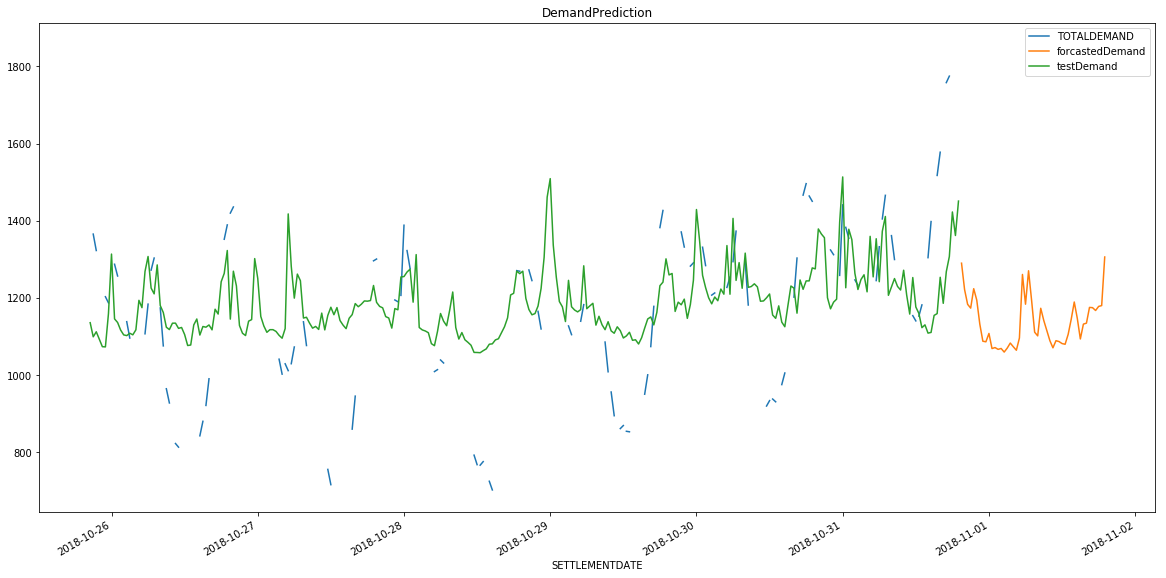

In [70]:
# DF,sc,sc_y,target_testDF,regressor,  X_train, X_test, y_train, y_test, forcast_ip_scaled, header,report_dict

predicted_stock_demand = regressor.predict(X_test)    #This should be from row no 2 to 9
predicted_stock_demand = sc_target.inverse_transform(predicted_stock_demand).round(2)

forcast_demand = regressor.predict(forcast_ip_scaled.reshape(48,1,1))     #This should give row no 10 for 9th row input

forcast_demand = sc_target.inverse_transform(forcast_demand).round(2)  #This should give row no 10
print(test_DF.shape)
testDemand = regressor.predict(test_DF.reshape(test_DF.shape[0],test_DF.shape[1],1))              
testDemand = sc_target.inverse_transform(testDemand).round(2)

# Creating Data Frame for visualisation and storage.



# Get future n dates for forcased values
def get_dates(duration,basedate):
    from datetime import datetime
    date =  basedate
    dates = pd.DataFrame(index=pd.date_range(date, periods=duration+1, freq='1800s')).iloc[1:,:]
    return dates

result = pd.DataFrame()
result = pd.concat([result, dataset.iloc[-(X_test.shape[0]+48):-48,1]], axis=1)
result['testDemand'] = testDemand

td_df = pd.DataFrame(index=result.index)
td_df['testDemand'] = testDemand.round(2)
result = pd.concat([result,td_df])

# result['PredictedDemand'] = predicted_stock_demand.reshape(X_test.shape[0],).tolist()
print(result.tail())

fs_df = get_dates(48,result.index[-1])
fs_df['forcastedDemand'] = forcast_demand.round(2)
fs_df.index.names = ['SETTLEMENTDATE']
print(fs_df.tail())
result = pd.concat([result,fs_df])
result.plot(legend=True, title='DemandPrediction')



In [71]:
plt.savefig('result1.png')

In [72]:
result.to_csv('result1.csv')
